# Quarry Production and Downtime EDA

The following data is collected from a limestone quarry. We can assume that under ideal conditions, downtime is minimized and material is blasted, moved, processed, and shipped 24/7. The purpose of this notebook is to load, clean, and analyze two important measures:

(1) Daily Total Production (Tonnes)

(2) Downtime Events

In [80]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
# Load CSVs
dfprod = pd.read_csv("/Users/eliasforsberg/Documents/GitHub/quarry-eda/data/dfprod.csv")
dfdown = pd.read_csv("/Users/eliasforsberg/Documents/GitHub/quarry-eda/data/dfdown.csv")

### Inspect Dataframes and Change Data Types

First change production data types

In [82]:
dfprod

,Date,Actual Tonnage
0,2024-01-01,0
1,2024-01-02,"6,267"
2,2024-01-03,"21,831"
3,2024-01-04,"17,462"
4,2024-01-05,"18,090"
...,...,...
324,2024-11-20,"12,176"
325,2024-11-21,12172
326,2024-11-22,20119
327,2024-11-23,0


In [83]:
dfprod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            329 non-null    object
 1   Actual Tonnage  329 non-null    object
dtypes: object(2)
memory usage: 5.3+ KB


In [84]:
# Convert features to useful data types
dfprod["Date"] = pd.to_datetime(dfprod["Date"])
dfprod["Actual Tonnage"] = dfprod["Actual Tonnage"].str.replace(',', '').astype(int)

Next, change downtime data types as required

In [85]:
dfdown

,Date,Downtime Description,Start Time [24:00],End Time [24:00],Downtime Category,Duration (minutes),D_Change produced material,D_Electrical/Mechanical,D_Lack of feed,D_Meetings/Breaks/Training,D_Planned Maintenance,D_Production Stoppage,D_Rate loss,D_Start up/Shut Down,D_Weather/Environmental
0,2024-01-04,SAFETY TALK,2024-01-04 00:00:00,2024-01-04 00:15:00,Meetings/Breaks/Training,15,False,False,False,True,False,False,False,False,False
1,2024-01-04,CC AND TRAVEL,2024-01-04 00:15:00,2024-01-04 00:45:00,Start up/Shut Down,30,False,False,False,False,False,False,False,True,False
2,2024-01-04,LUNCH,2024-01-04 04:30:00,2024-01-04 05:15:00,Meetings/Breaks/Training,45,False,False,False,True,False,False,False,False,False
3,2024-01-04,SAFETY TALK,2024-01-04 08:00:00,2024-01-04 08:15:00,Meetings/Breaks/Training,15,False,False,False,True,False,False,False,False,False
4,2024-01-04,CC AND TRAVEL,2024-01-04 08:15:00,2024-01-04 08:30:00,Start up/Shut Down,15,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,2024-11-24,CHANGE SCREEN GATES,2024-11-24 00:00:00,2024-11-24 01:12:00,Electrical/Mechanical,72,False,True,False,False,False,False,False,False,False
5818,2024-11-24,REMOVING ROCK FROM TAIL PULLEY,2024-11-24 01:49:00,2024-11-24 02:04:00,Electrical/Mechanical,15,False,True,False,False,False,False,False,False,False
5819,2024-11-24,LOW FEED,2024-11-24 10:21:00,2024-11-24 10:54:00,Lack of feed,33,False,False,True,False,False,False,False,False,False
5820,2024-11-24,VF4 PLUGGED,2024-11-24 11:12:00,2024-11-24 11:23:00,Electrical/Mechanical,11,False,True,False,False,False,False,False,False,False


In [86]:
dfdown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        5822 non-null   object
 1   Downtime Description        5822 non-null   object
 2   Start Time [24:00]          5811 non-null   object
 3   End Time [24:00]            5810 non-null   object
 4   Downtime Category           5817 non-null   object
 5   Duration (minutes)          5822 non-null   int64 
 6   D_Change produced material  5822 non-null   bool  
 7   D_Electrical/Mechanical     5822 non-null   bool  
 8   D_Lack of feed              5822 non-null   bool  
 9   D_Meetings/Breaks/Training  5822 non-null   bool  
 10  D_Planned Maintenance       5822 non-null   bool  
 11  D_Production Stoppage       5822 non-null   bool  
 12  D_Rate loss                 5822 non-null   bool  
 13  D_Start up/Shut Down        5822 non-null   bool

In [87]:
# Convert features to useful data types
dfdown["Date"] = pd.to_datetime(dfdown["Date"])
dfdown["Start Time [24:00]"] = pd.to_datetime(dfdown["Start Time [24:00]"])
dfdown["End Time [24:00]"] = pd.to_datetime(dfdown["End Time [24:00]"])
dfdown["Duration (minutes)"] = dfdown["Duration (minutes)"].astype(int)

### Observations

Lets first take a look at the production dataframe. Descriptive information will give a useful overview.

In [88]:
dfprod.describe()

,Date,Actual Tonnage
count,329,329.000000
mean,2024-06-13 00:00:00,11035.188450
min,2024-01-01 00:00:00,0.000000
25%,2024-03-23 00:00:00,4843.000000
50%,2024-06-13 00:00:00,12322.000000
75%,2024-09-03 00:00:00,17481.000000
max,2024-11-24 00:00:00,23927.000000
std,NaN,7449.202362


In [89]:
print((dfprod["Actual Tonnage"] == 0).sum())

68


From the information above, we can see that there are no negative values (although there are a fair number of zeros)

Lets figure out the shape of our production data distribution to see if there are any obvious outliers.

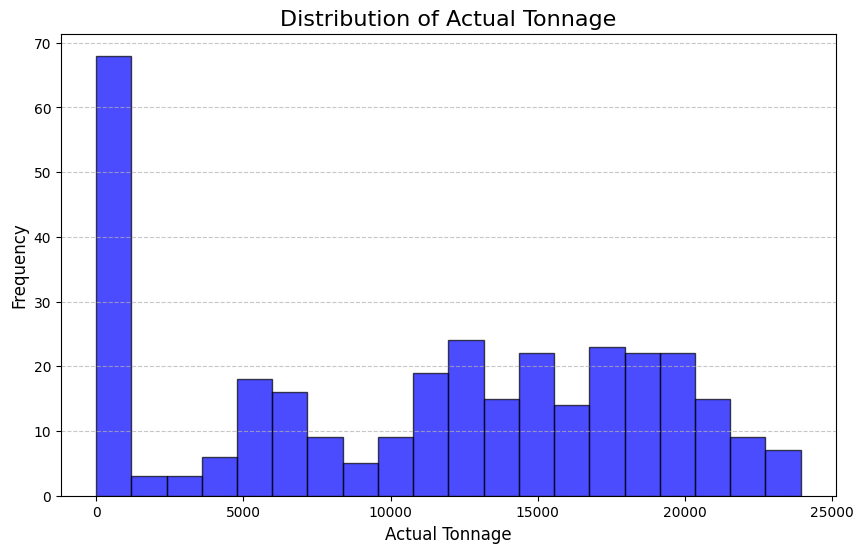

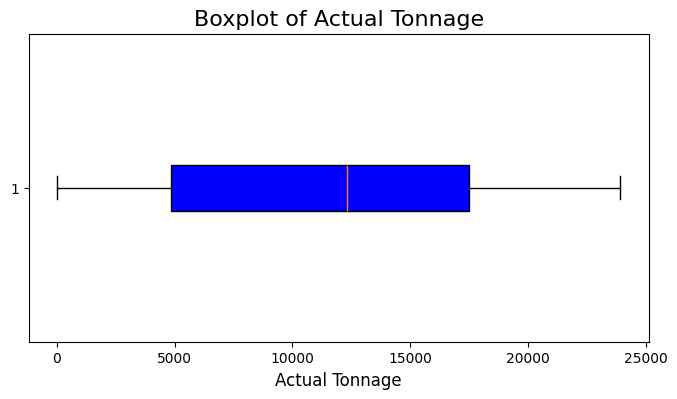

In [90]:
# Plot the distribution using a histogram
plt.figure(figsize=(10, 6))
plt.hist(dfprod["Actual Tonnage"], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Actual Tonnage", fontsize=16)
plt.xlabel("Actual Tonnage", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(dfprod["Actual Tonnage"], vert=False, patch_artist=True, boxprops=dict(facecolor="blue"))
plt.title("Boxplot of Actual Tonnage", fontsize=16)
plt.xlabel("Actual Tonnage", fontsize=12)
plt.show()

From the histogram, we see a large number of zeros and semi-uniform distribution (with lots of variance).

Lets see how those no production days are distributed. Was there one big stoppage or are they normally disributed in the timeseries?

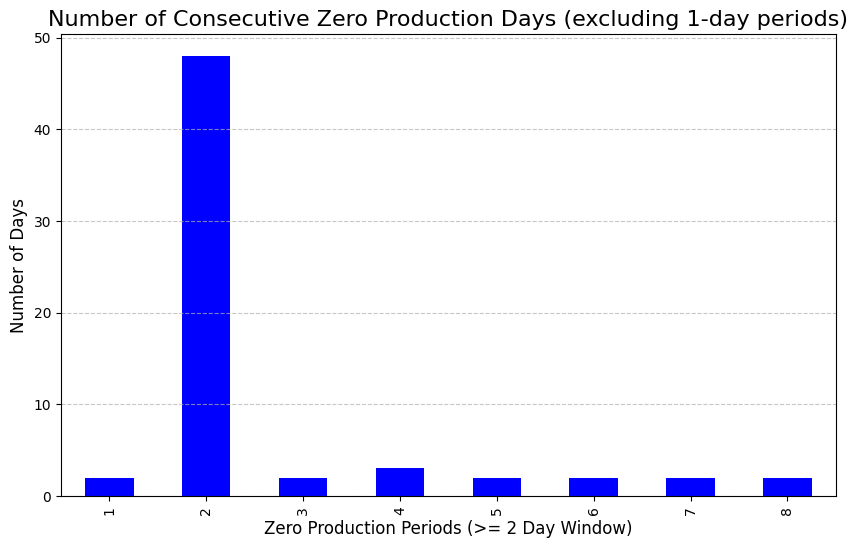

In [91]:
# Create a boolean mask for zero tonnage
dfprod["Zero Tonnage"] = dfprod["Actual Tonnage"] == 0

# Create a column for consecutive zero production days (assign a group number)
dfprod['Group'] = (dfprod['Zero Tonnage'] != dfprod['Zero Tonnage'].shift()).cumsum()

# Filter for the rows where "Zero Tonnage" is True (i.e., production is zero)
zero_tonnage_groups = dfprod[dfprod["Zero Tonnage"]]

# Count the length of each consecutive zero period
zero_counts = zero_tonnage_groups.groupby('Group').size()

# Filter out groups with only one day of zero production
zero_counts = zero_counts[zero_counts > 1]

# Reindex the groups to start from 1
zero_counts.index = range(1, len(zero_counts) + 1)

# Plot the distribution of consecutive zero days
plt.figure(figsize=(10, 6))
zero_counts.plot(kind='bar', color='blue')
plt.title("Number of Consecutive Zero Production Days (excluding 1-day periods)", fontsize=16)
plt.xlabel("Zero Production Periods (>= 2 Day Window)", fontsize=12)
plt.ylabel("Number of Days", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Looking at the groups of stoppage that where greater or equal to 2 days, we can see there was one stoppage that lasted nearly 50 days. Lets see when this occured.

In [102]:
# Find the group with the longest stoppage period
max_stoppage_group = zero_counts.idxmax()

# Get the start and end dates for the longest stoppage
max_stoppage_dates = dfprod[dfprod['Group'] == max_stoppage_group]
start_date = max_stoppage_dates['Date'].min()
end_date = max_stoppage_dates['Date'].max()

print(f"{start_date} - {end_date}")
print(end_date - start_date)


2024-02-01 00:00:00 - 2024-03-19 00:00:00
47 days 00:00:00


The window of 47 days occured from Feb 2, 2024 to Mar 19, 2024. After further online research, it appears that many quarrys in Canada close down in the winter for repairs due to the adverse affect of weather on productivity.